# Artificial rewards

The only reward (goals) is very sparse. Use this to add expert-defined rewards to each (s, a) pair.

In [1]:
# PARAMS
EXPERT_PLAYER_IDX = 0
USE_GPU = False

GAMES = [{"id": gameID} for gameID in ["noBoost1v1_1", "noBoost1v1_2", "noBoost1v1_3"]]

# NOTE: can't use __file__ in jupyter notebook unfortunately, so hard-code it insteadL
ROOT_PROJECT_PATH = 'C:/Users/User/code/CPSC533V/project'

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
DEVICE = torch.device("cuda" if USE_GPU else "cpu")

# Load local reusable code within 'lib/'
sys.path.append(ROOT_PROJECT_PATH)
import lib.files as libFiles
import lib.preprocess as libPreprocess
import lib.rewards as libRewards
from lib.StoAModel import StoA_Model

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
for game in GAMES:
    game['data'] = libFiles.parseReplayToGameData(game['id'])
    libFiles.cleanAndDisplayGameData(game['data'])
    
    game['playerStates'], game['playerActions'] = [], []
    for p in game['data'].players:
        game['playerStates' ].append(libPreprocess.cleanPlayerStates( p.data    ))
        game['playerActions'].append(libPreprocess.cleanPlayerActions(p.controls))
    game['ballStates'] = libPreprocess.cleanBallStates(game['data'].ball)
    print ("Game data from '%s' preprocessed." % game['id'])
    print ("    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys\n")

Loading...
	replays\noBoost1v1_1.replay


Could not find field_of_view in camera settings for Sundown
Could not find height in camera settings for Sundown
Could not find pitch in camera settings for Sundown
Could not find distance in camera settings for Sundown
Could not find stiffness in camera settings for Sundown
Could not find swivel_speed in camera settings for Sundown
Could not find transition_speed in camera settings for Sundown
D:/projects/carball\carball\controls\rotations.py:87: RuntimeWarning: invalid value encountered in sign
  rhs[1] / (T_p + np.sign(rhs[1]) * omega[1] * D_p),
D:/projects/carball\carball\controls\rotations.py:88: RuntimeWarning: invalid value encountered in sign
  rhs[2] / (T_y - np.sign(rhs[2]) * omega[2] * D_y)


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12921 data points acquired
====


Game data from 'noBoost1v1_1' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Loading...
	replays\noBoost1v1_2.replay


Could not find field_of_view in camera settings for Beast
Could not find height in camera settings for Beast
Could not find pitch in camera settings for Beast
Could not find distance in camera settings for Beast
Could not find stiffness in camera settings for Beast
Could not find swivel_speed in camera settings for Beast
Could not find transition_speed in camera settings for Beast


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12016 data points acquired
====


Game data from 'noBoost1v1_2' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Loading...
	replays\noBoost1v1_3.replay


Could not find field_of_view in camera settings for Middy
Could not find height in camera settings for Middy
Could not find pitch in camera settings for Middy
Could not find distance in camera settings for Middy
Could not find stiffness in camera settings for Middy
Could not find swivel_speed in camera settings for Middy
Could not find transition_speed in camera settings for Middy


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12682 data points acquired
====


Game data from 'noBoost1v1_3' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys



## Artificial rewards system

Rewards are sparse and hard to achieve for randomly initialized agents.

Instead, we provide artificial rewards that promote good behaviour even without scoring a goal:

*State rewards*:
* The agent being near the ball
* The agent being between their own goal and the ball
* The agent having boost
* The ball being near the goal the agent is shooting towards.

*Action rewards*:
* The agent is driving forwards
* The agent is not turning
* The agent is not boosting

Each has its own importance factor, and the two are mixed with weights as well.  
The code is not defined in this notebook, instead see `lib/rewards.py`


### Reward verification

Check each game, to ensure the expert scores well in the rewards.

Rewards for noBoost1v1_1
    Artificial rewards for expert...
        Total: 11327 (0.876711 per frame)
    Artificial rewards for bot...
        Total: 10605 (0.820776 per frame)


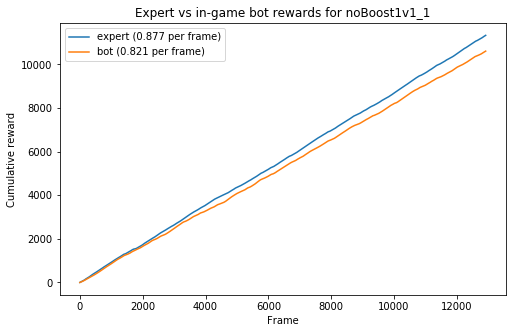

Rewards for noBoost1v1_2
    Artificial rewards for expert...
        Total: 10426 (0.867718 per frame)
    Artificial rewards for bot...
        Total: 9517 (0.792101 per frame)


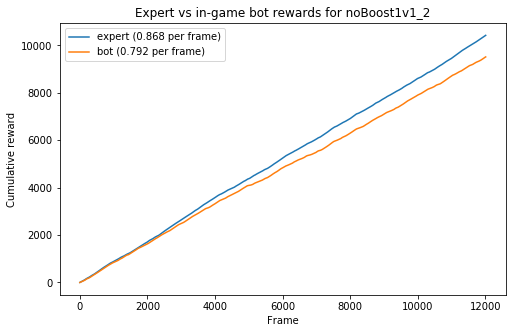

Rewards for noBoost1v1_3
    Artificial rewards for expert...
        Total: 10970 (0.865064 per frame)
    Artificial rewards for bot...
        Total: 10079 (0.794785 per frame)


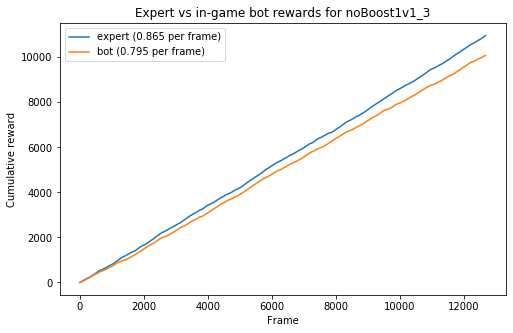

In [13]:
def compareRewards(coefOverrides={}):
    for game in GAMES:
        gameData = game['data']
        print ("Rewards for %s" % game['id'])
        for i in range(len(gameData.players)):
            print ("    Artificial rewards for %s..." % gameData.players[i].name)
            allS, allA = libPreprocess.stateAndActionsForPlayer(game, i)

            rewards = []
            for t in range(allS.shape[0]):
                s, a = allS.iloc[t], allA.iloc[t]
                r = libRewards.artificialReward(s, a, coefOverrides)
                rewards.append(r)
            print ("        Total: %d (%f per frame)" % (np.sum(rewards), np.mean(rewards)))
            plt.plot(np.cumsum(rewards), label=("%s (%.3f per frame)" % (gameData.players[i].name, np.mean(rewards))))
            plt.xlabel("Frame")
            plt.ylabel("Cumulative reward")
            plt.title("Expert vs in-game bot rewards for %s" % game['id'])

        plt.legend()
        plt.show()
        
compareRewards()

Rewards for noBoost1v1_1
    Artificial rewards for expert...
        Total: 12175 (0.942269 per frame)
    Artificial rewards for bot...
        Total: 9860 (0.763105 per frame)


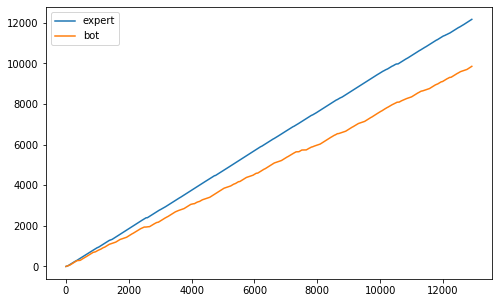

Rewards for noBoost1v1_2
    Artificial rewards for expert...
        Total: 10388 (0.864552 per frame)
    Artificial rewards for bot...
        Total: 8997 (0.748815 per frame)


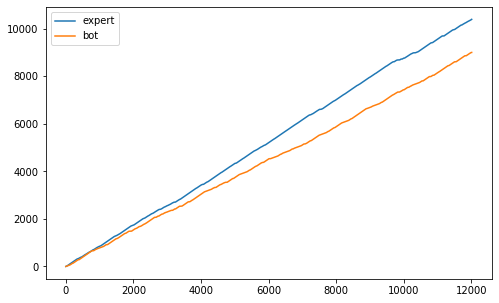

Rewards for noBoost1v1_3
    Artificial rewards for expert...
        Total: 10777 (0.849837 per frame)
    Artificial rewards for bot...
        Total: 9825 (0.774736 per frame)


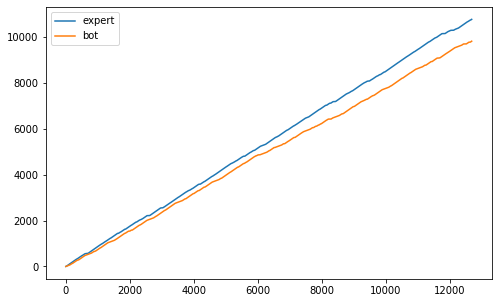

In [10]:
nearBallOnlyCoef = {}
for key in libRewards.DEFAULT_COEF.keys():
    nearBallOnlyCoef[key] = 0.0
nearBallOnlyCoef['forwards'] = 1.0
nearBallOnlyCoef['action'] = 1.0

compareRewards(coefOverrides=nearBallOnlyCoef)

Rewards for noBoost1v1_1
    Artificial rewards for expert...
        Total: 12175 (0.942269 per frame)
    Artificial rewards for bot...
        Total: 9860 (0.763105 per frame)


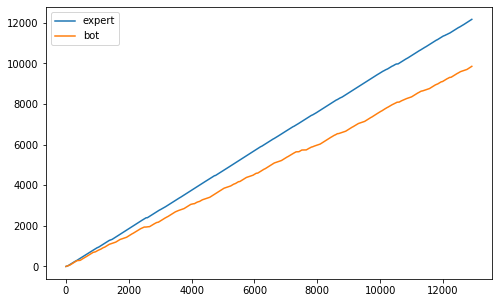

Rewards for noBoost1v1_2
    Artificial rewards for expert...
        Total: 10388 (0.864552 per frame)
    Artificial rewards for bot...
        Total: 8997 (0.748815 per frame)


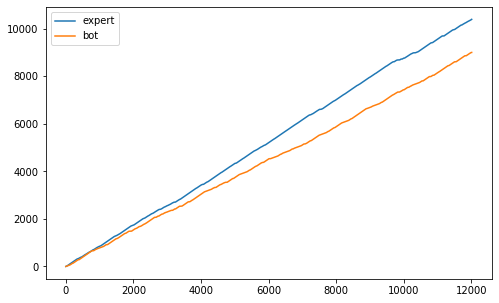

Rewards for noBoost1v1_3
    Artificial rewards for expert...
        Total: 10777 (0.849837 per frame)
    Artificial rewards for bot...
        Total: 9825 (0.774736 per frame)


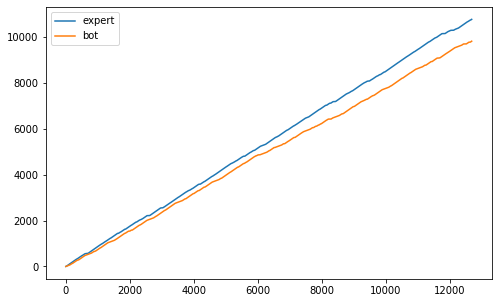

In [11]:
forwardsOnlyCoef = {}
for key in libRewards.DEFAULT_COEF.keys():
    forwardsOnlyCoef[key] = 0.0
forwardsOnlyCoef['forwards'] = 1.0
forwardsOnlyCoef['action'] = 1.0

compareRewards(coefOverrides=forwardsOnlyCoef)